In [1]:
import numpy as np

import pandas as pd

import seaborn as sns
import  matplotlib.pyplot as plt

from lib.mcalc import gcf2ann, spike2bin, spikeCoin

### Trial-by-trial variability

In [7]:
# data setting
D = 3.0
recpath = './data/var-D%.1f'%D
epoch = 10
T, dt = 2500, 0.1
Nm = 400

# Nfs = np.arange(0, 141, 20, dtype=int)
Nfs = np.arange(0, 101, 20, dtype=int)
Ws = np.array([0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2, 0.25])

extract = False

In [8]:
if extract:
    #  extract data from raw recordings
    frames = []
    binsize = 2
    for Nf in Nfs:
        if Nf > 0:
            nNums = [Nm, Nf]
        else:
            nNums = [Nm, 1]
        for W in Ws:
            label = '/Nf%d-W%.2f/'%(Nf, W)
            data = np.load(recpath + label + 'spk.npz')
            es, ts = data.f.arr_0, data.f.arr_1
            data.close()

            # processing data
            rates = []
            for e in range(epoch):
                ta, tb = e*T+500, (e+1)*T
                idx = (ts>=ta) & (ts<tb) & (es<=2*Nm)

                idBins = np.concatenate([[0], np.cumsum(nNums)]) + 1
                tmBins = np.arange(0, T+1-500, binsize)
                rates.append(np.histogram2d(ts[idx]-ta, es[idx], bins=[tmBins, idBins])[0])
            rates = np.array(rates)[:,:,0]
            
            # fano factor
            fanos = rates.var(axis=0)/rates.mean(axis=0);
            frames.append([Nf, W, np.mean(rates*1e3/Nm/binsize), np.mean(fanos[~np.isnan(fanos)])])

    colname = ['Nf', 'Win', 'rout', 'Fano']
    stats = pd.DataFrame(np.array(frames), columns=colname)

    np.savez('./exp/var/stats-D%.1f.npz'%D, np.array(frames))
    stats.to_csv('./exp/var/stats-D%.1f.csv'%D)

[0.61897381 0.72382741 0.8731336  0.97509507 1.05850148 1.18778433
 1.53241864 1.79427527 1.85040451 1.16387236 1.24820021 1.34247076
 1.4606633  1.5547287  1.68533678 2.003113   2.47802747 2.51812177] [0.61897381 0.72382741 0.8731336  0.97509507 1.05850148 1.18778433
 1.53241864 1.79427527 1.85040451] [1.16387236 1.24820021 1.34247076 1.4606633  1.5547287  1.68533678
 2.003113   2.47802747 2.51812177]


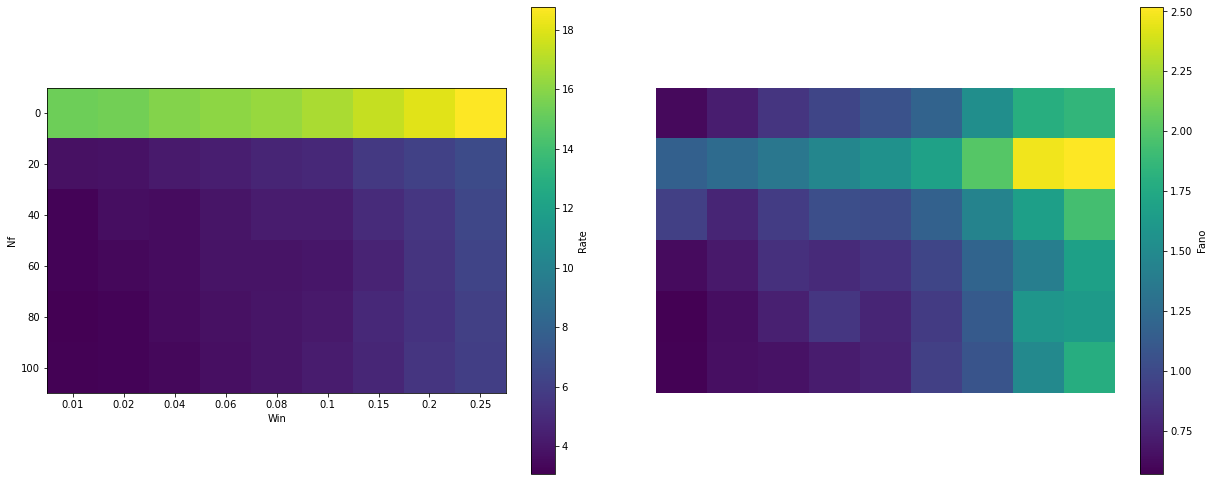

In [9]:
# load extracted data
data = np.load('./exp/var/stats-D%.1f.npz'%D)
frames = data.f.arr_0
data.close()

stats = pd.read_csv('./exp/var/stats-D%.1f.csv'%D)
fanos = stats['Fano'].to_numpy()
rates = stats['rout'].to_numpy()
fig_fano = np.reshape(fanos, newshape=(len(Nfs), len(Ws)));
fig_rate = np.reshape(rates, newshape=(len(Nfs), len(Ws)));
print(fanos[:18], fig_fano[0], fig_fano[1])

plt.subplots(1,2,figsize=(20,10))

plt.subplot(1,2,1)
im = plt.imshow(fig_rate)
plt.xlabel('Win')
plt.xticks(np.arange(len(Ws)), Ws);
plt.ylabel('Nf')
plt.yticks(np.arange(len(Nfs)), Nfs);
cbar = plt.colorbar(im, fraction=0.046)
cbar.set_label('Rate')

plt.subplot(1,2,2)
im = plt.imshow(fig_fano)
plt.axis('off')
cbar = plt.colorbar(im, fraction=0.046)
cbar.set_label('Fano')

### Temporal correlation

In [48]:
# data setting
D = 1.0
recpath = './data/cor-D%.1f'%D
epoch = 10
T, dt = 2000, 0.1
Nm = 200

Nfs = np.arange(0, 101, 20, dtype=int)
Ws = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.25])
Bs = np.array([0.1, 0.2, 0.3, 0.5, 0.7, 0.9])

In [49]:
# extract data from raw recordings
frames = []
binKernel = np.ones(int(5 / dt))
grpsize = 20
binsize = 10
for Nf in Nfs:
    if Nf > 0:
        nNums = [Nm, Nm, Nf]
    else:
        nNums = [Nm, Nm, 1]
    for W in Ws:
        for B in Bs:
            label = '/Nf%d-W%.2f-B%.2f/'%(Nf, W, B)
            data = np.load(recpath + label + 'spk.npz')
            es, ts = data.f.arr_0, data.f.arr_1
            data.close()

            # processing data
            rates = []
            corrs = []
            for e in range(epoch):
                ta, tb = e*T+500, (e+1)*T
                idx = (ts>=ta) & (ts<tb) & (es<=2*Nm)

                idBins = np.arange(1, 2*Nm+2, grpsize)
                tmBins = np.arange(0, T+1-500, binsize)
                rates.append(np.histogram2d(ts[idx]-ta, es[idx], bins=[tmBins, idBins])[0]*1e3/binsize/grpsize)

                coV = np.corrcoef(rates[-1].T)
                np.fill_diagonal(coV, 0.)

                ng = int(Nm/grpsize)
                ix = np.arange(0, ng)
                corrs.append([   (np.sum(coV[np.ix_(ix, ix)])/ng/(ng-1) + np.sum(coV[np.ix_(ix+ng, ix+ng)])/ng/(ng-1))/2,
                                np.sum(coV[np.ix_(ix, ix+ng)])/ng/ng])

            # output correlations
            corrs = np.array(corrs)
            frames.append([Nf, W, B, corrs[:,0].mean(), corrs[:,1].mean()])

colname = ['Nf', 'Win', 'Bin', 'Wout', 'Bout']
stats = pd.DataFrame(np.array(frames), columns=colname)

np.savez('./exp/cor/stats-D%.1f.npz'%D, np.array(frames))
stats.to_csv('./exp/cor/stats-D%.1f.csv'%D)

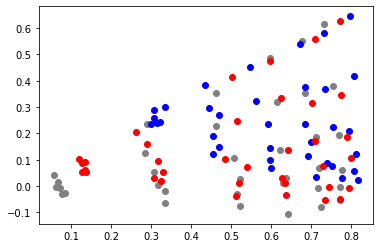

In [50]:
# load extracted data
data = np.load('./exp/cor/stats-D%.1f.npz'%D)
frames = data.f.arr_0
data.close()

stats = pd.read_csv('./exp/cor/stats-D%.1f.csv'%D)

cors = stats[['Nf', 'Wout', 'Bout']]

plt.scatter(cors.loc[cors['Nf']==0, 'Wout'], cors.loc[cors['Nf']==0, 'Bout'], c='gray')
plt.scatter(cors.loc[cors['Nf']==20, 'Wout'], cors.loc[cors['Nf']==20, 'Bout'], c='blue')
plt.scatter(cors.loc[cors['Nf']==100, 'Wout'], cors.loc[cors['Nf']==100, 'Bout'], c='red')

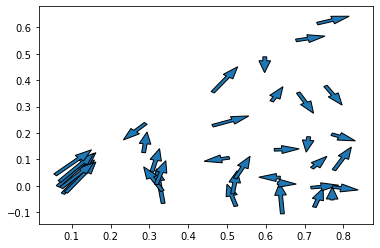

In [54]:
va, vb = 0, 100
wa, ba = cors.loc[cors['Nf']==va, 'Wout'], cors.loc[cors['Nf']==va, 'Bout']
wb, bb = cors.loc[cors['Nf']==vb, 'Wout'], cors.loc[cors['Nf']==vb, 'Bout']

for x, y, xx, yy in zip(wa, ba, wb, bb):
    plt.arrow(x, y, xx-x, yy-y, width=0.01);